# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> Data Science 2: Advanced Topics in Data Science
## Homework 5 Part 1: Fine Tuning Llama3


**Harvard University**<br/>
**Spring 2025**<br/>
**Instructors**: Pavlos Protopapas, Natesh Pillai, and Chris Gumb


<hr style="height:2pt">

In [1]:
# RUN THIS CELL
import requests
from IPython.core.display import HTML
styles = requests.get(
    "https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/"
    "content/styles/cs109.css"
).text
HTML(styles)

In [2]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np

from datasets import Dataset
from scipy.special import softmax
from sklearn.preprocessing import LabelEncoder
from transformers import (
    BitsAndBytesConfig,
    LlamaPreTrainedModel,
    LlamaModel,
    AutoTokenizer,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
    set_seed
)
from transformers import LlamaPreTrainedModel, LlamaModel
from transformers.modeling_outputs import SequenceClassifierOutput
from huggingface_hub import notebook_login, login
import torch
import torch.nn as nn

from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training, TaskType
from sklearn.metrics import log_loss, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt

import time
import random
import os
import json
import gc
from collections import namedtuple

def setup_seed(seed):
    '''Sets the seed of the entire notebook so results are the same every time we run.'''
    random.seed(seed)
    set_seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)

setup_seed(42)

2025-05-03 11:33:05.538020: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-03 11:33:05.538067: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-03 11:33:05.538716: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-03 11:33:05.543703: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Some PyTorch settings
print(f"PyTorch version: {torch.__version__}")
print(f"GPU availablity: \n{torch.cuda.is_available()}\n")

TRAIN_CSV = "data/chatbot_arena_conversations.csv"
model_path = "meta-llama/Llama-3.2-3B-Instruct"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
MAX_LENGTH = 1024

PyTorch version: 2.1.0.post303
GPU availablity: 
True



In [4]:
# measure notebook runtime
time_start = time.time()

<div style = "background: lightsalmon; border: thin solid black; border-radius: 2px; padding: 5px">

### Instructions
- To submit your notebook, follow the instructions given in on the Canvas assignment page.
- Plots should be legible and interpretable *without having to refer to the code that generated them*. They should includelabels for the $x$- and $y$-axes as well as a descriptive title and/or legend when appropriate.
- When asked to interpret a visualization, do not simply describe it (e.g., "the curve has a steep slope up"), but instead explain what you believe the plot *means*.
- Autograding tests are mostly to help you debug. The tests are not exhaustive so simply passing all tests may not be sufficient for full credit.
- The use of *extremely* inefficient or error-prone code (e.g., copy-pasting nearly identical commands rather than looping) may result in only partial credit.
- We have tried to include all the libraries you may need to do the assignment in the imports cell provided below. Please get course staff approval before importing any additional 3rd party libraries.
- Enable scrolling output on cells with very long output.
- Feel free to add additional code or markdown cells as needed.
- Ensure your code runs top to bottom without error and passes all tests by restarting the kernel and running all cells (note that this can take a few minutes).
- **You should do a "Restart Kernel and Run All Cells" before submitting to ensure (1) your notebook actually runs and (2) all output is visible**
</div>


<a id="contents"></a>

## Notebook Contents

- [**PART 1: Fine Tuning LLM**](#part1)


## About this Homework

In this homework, we will explore how to fine-tune an LLM for a classification task. In particular we will be fine tuning a [Llama3.2 3B model](https://huggingface.co/meta-llama/Llama-3.2-3B-Instruct)

- In [PART 1](#part1), we will begin by building a classifier for [Chatbot Arena Conversations dataset](https://huggingface.co/datasets/lmsys/chatbot_arena_conversations)


**IMPORTANT NOTES:**

- LLMs are insanely computationally intensive.
- **We highly recommend that you train your model on a system using GPUs. For this, we recommend using the [GPU-enabled Jupyter environment](https://ood.huit.harvard.edu/pun/sys/dashboard/batch_connect/sys/ood-jupyterlab-spack-conda/cs1090b/session_contexts/new) provided to you as part of this course.**
- Models that take hours to train on CPUs can be trained in just minutes when using GPUs.
- **To avoid getting frustrated by having to re-train your models every time you run your notebook, you should save your trained model weights for later use.** Model history dictionaries can also be saved to disk with `pickle` and checked with an `if not` condition. This is a great way to check if the model weights exist before training, preventing redundant retraining. Please, think of the penguins! 🐧

**KERNEL CRASHES:**

If your kernel crashes as you attempt to train your model, please check the following items:
- Models with too many parameters might not fit in GPU memory. Try reducing the size of your model.
- A large `batch_size` will attempt to load too many samples in GPU memory. Avoid using a very large batch size.
- Avoid creating multiple copies of the data.



<a id="part1"></a>
    
<!-- <div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA"> -->

# PART 1: Fine-Tuning LLMs (50 Points)


<a id="part1intro"></a>

## Overview

[Return to contents](#contents)

In this question, you will work with the [Chatbot Arena Conversations dataset](https://huggingface.co/datasets/lmsys/chatbot_arena_conversations) to build a preference prediction model. Your task is to predict which responses users will prefer when presented with two competing answers generated by different large language models (LLMs). The dataset contains a curated subset of conversations from the [Chatbot Arena platform](https://lmarena.ai/), where human users evaluate responses from various LLMs in head-to-head comparisons. You will fine tune Llama 3.2 3B instruct model that can analyze the user's prompt and the generated responses to determine which response users are more likely to prefer.

Learn more about Chatbot Arena here -> [https://arxiv.org/abs/2403.04132](https://arxiv.org/abs/2403.04132)

[Llama 3.2 Models](https://ai.meta.com/blog/llama-3-2-connect-2024-vision-edge-mobile-devices//)

**Note:** The dataset contains conversations that may be unsafe, offensive, or upsetting.

<div class="alert alert-success" style="color: #333; background-color: #e8fffb; border-color: #bcfff2; border-width: 1px; border-radius: 3px; padding: 10px;">

<a id="q11"></a>

<b>1.1 Initial Preprocessing</b>
<hr>

<b>Q1.1.1 - Preprocessing</b>

<a id="q111"></a>

- We provide the code for this part. We will use a separate script for this part - which will be executed just once.
```python
%%writefile dataset_format.py
## preprocessing code here
```
- `dataset_fomat.py` script does following - 

- Loads [Chatbot Arena Conversations dataset](https://huggingface.co/datasets/lmsys/chatbot_arena_conversations) using [HuggingFace Dataset](https://huggingface.co/docs/datasets/v3.4.1/en/package_reference/loading_methods#datasets.load_dataset)
- Converts dataset to pandas dataframe
- Filters dataset for English language only
- Separates conversations into - prompt, response_a (this is response from model_a) and response_b (this is response from model_b). Take a closer look at prompts, response_a and response_b - they are all lists, some lists have multiple prompts - these are called multi turn prompts.
- To simplify the problem at hand, we drop all rows where there are no clear winners i.e drop rows with winner=='tie'.  Dataset contains much fewer samples where winner==tie.
- Keeps only single turn conversations. Multiturn conversations can be very long and much harder to predict correctly.
- Apply `utf-8` encoding/decoding for consistency and to avoid any potential tokenization errors.

</div>


In [5]:
notebook_login()

In [6]:
%%writefile dataset_format.py

import numpy as np
import pandas as pd
import json

from tqdm.auto import tqdm
tqdm.pandas()

# pip install datasets
from datasets import load_dataset

# Load the chatbot arena conversations dataset from HuggingFace
dataset = load_dataset("lmsys/chatbot_arena_conversations", token=True)
print(dataset)
# Convert the dataset to a pandas DataFrame
df = dataset["train"].to_pandas()
df = df[df.language=='English'].reset_index(drop=True)
print(df.shape)

def separate_conversations(conv):
    user_texts      = [x['content'] for x in conv if x['role'] == 'user']
    assistant_texts = [x['content'] for x in conv if x['role'] == 'assistant']

    return user_texts, json.dumps(assistant_texts)


df['prompt_a'], df['response_a'] = zip(*df.conversation_a.progress_apply(separate_conversations))
df['prompt_b'], df['response_b'] = zip(*df.conversation_b.progress_apply(separate_conversations))


assert (df['prompt_a'] == df['prompt_b']).all() == True

df['prompt'] = df['prompt_a'].progress_apply(json.dumps)

def one_hot_encode(winner):
    return pd.Series([int('model_a'==winner), int('model_b'==winner), int('tie'==winner or 'tie (bothbad)'==winner)])

df[['winner_model_a', 'winner_model_b', 'winner_tie']] = df.winner.progress_apply(one_hot_encode)

cols = ['question_id', 'model_a', 'model_b', 'prompt', 'response_a',
        'response_b', 'winner_model_a', 'winner_model_b', 'winner_tie']

df = pd.DataFrame(df[cols].copy().values, columns=cols).reset_index(drop=True)

## Remove ties
df = df[df.winner_tie==0].reset_index(drop=True)
df.drop(columns=['winner_tie'], inplace=True)

df['id'] = df.index

df['prompt_length'] = df['prompt'].apply(lambda x: len(eval(x)))
df['response_a_length'] = df['response_a'].apply(lambda x: len(eval(x)))
df['response_b_length'] = df['response_b'].apply(lambda x: len(eval(x)))

df = df[df['prompt_length'] == 1].reset_index(drop=True)

df['prompt'] = df['prompt'].apply(lambda x: eval(x)[0])
df['response_a'] = df['response_a'].apply(lambda x: eval(x)[0])
df['response_b'] = df['response_b'].apply(lambda x: eval(x)[0])

df['prompt'] = df['prompt'].apply(lambda x: x.encode('utf-8', 'ignore').decode('utf-8'))
df['response_a'] = df['response_a'].apply(lambda x: x.encode('utf-8', 'ignore').decode('utf-8'))
df['response_b'] = df['response_b'].apply(lambda x: x.encode('utf-8', 'ignore').decode('utf-8'))

df.drop(columns=['prompt_length', 'response_a_length', 'response_b_length'], inplace=True)

print(df.shape)
print(df.head(1).T)

df.to_csv('data/chatbot_arena_conversations.csv', index=False)


Overwriting dataset_format.py


In [7]:
if not os.path.exists('data/chatbot_arena_conversations.csv'):
    !mkdir -p data
    !python dataset_format.py

<div class="alert alert-success" style="color: #333; background-color: #e8fffb; border-color: #bcfff2; border-width: 1px; border-radius: 3px; padding: 10px;">
    
<b>Q1.1.2</b>

<a id="q112"></a>
**Further preprocessing and loading dataset**
- Load the dataset from `data/chatbot_arena_conversations.csv` file in a pandas dataframe.
- Create binary label `label` from the winner columns (`winner_model_a` or `winner_model_b`). 
Note: `winner_model_b==1` => `label=1` => Model b is winner.
- Perform preliminary EDA 
- Display dataset shape, `.head()` and target class ratio.

</div>

Shape: (18320, 10)


,question_id,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,id,label
0,58210e39b3fd4441a2bd4a518bb44c2d,chatglm-6b,koala-13b,What is the difference between OpenCL and CUDA?,OpenCL and CUDA are two different programming ...,OpenCL and CUDA are both programming languages...,0,1,0,1
1,90bfd142157948aba01931726c888e7f,koala-13b,oasst-pythia-12b,"Fuji vs. Nikon, which is better?",Both Fuji and Nikon are popular camera brands ...,This is a subjective question and the answer d...,0,1,1,1
2,a7c5accc53e649a3bc6b2e41d962ebc4,vicuna-13b,oasst-pythia-12b,How to build an arena for chatbots?,Building an arena for chatbots can be done by ...,Building an arena for chatbots is a great way ...,0,1,2,1
3,adf27e819a3c494cb6e993f0c660e097,vicuna-13b,koala-13b,When is it today?,"I'm sorry, I cannot determine the current date...","Today is February 23, 2023.",1,0,3,0
4,c0fc42c6f5f14f2aa5a89f71f8553730,vicuna-13b,koala-13b,Count from 1 to 10 with step = 3,"1, 4, 7, 10\n\nCounting with a step of 3 means...","1, 4, 7, 10",1,0,4,0



Class, 0 -> model_a won, 1 -> model_b won:
label
0    0.505022
1    0.494978
Name: proportion, dtype: float64


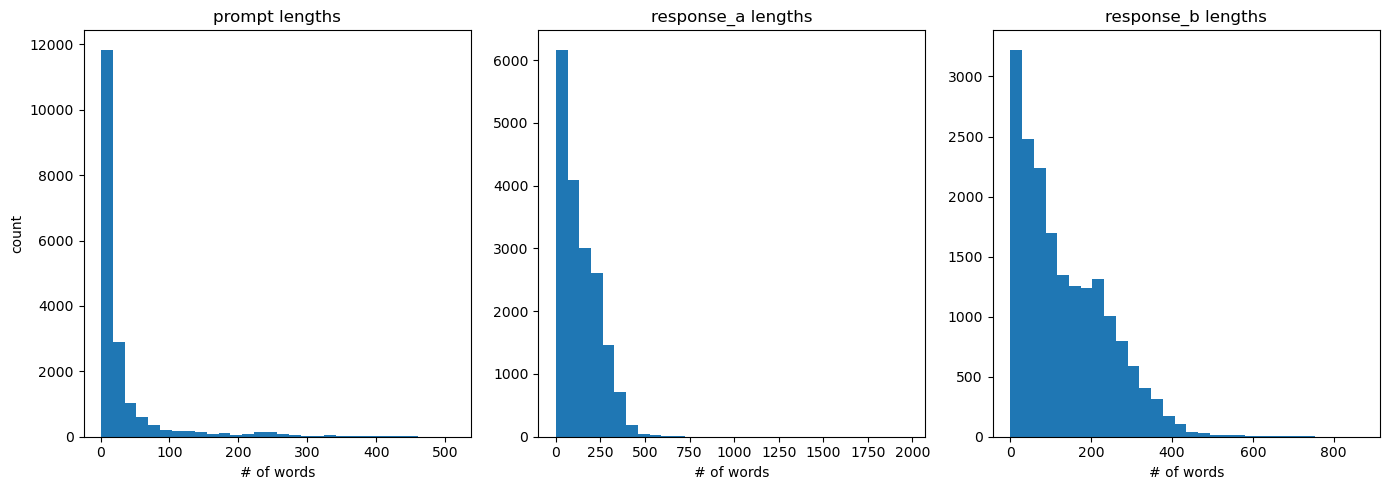

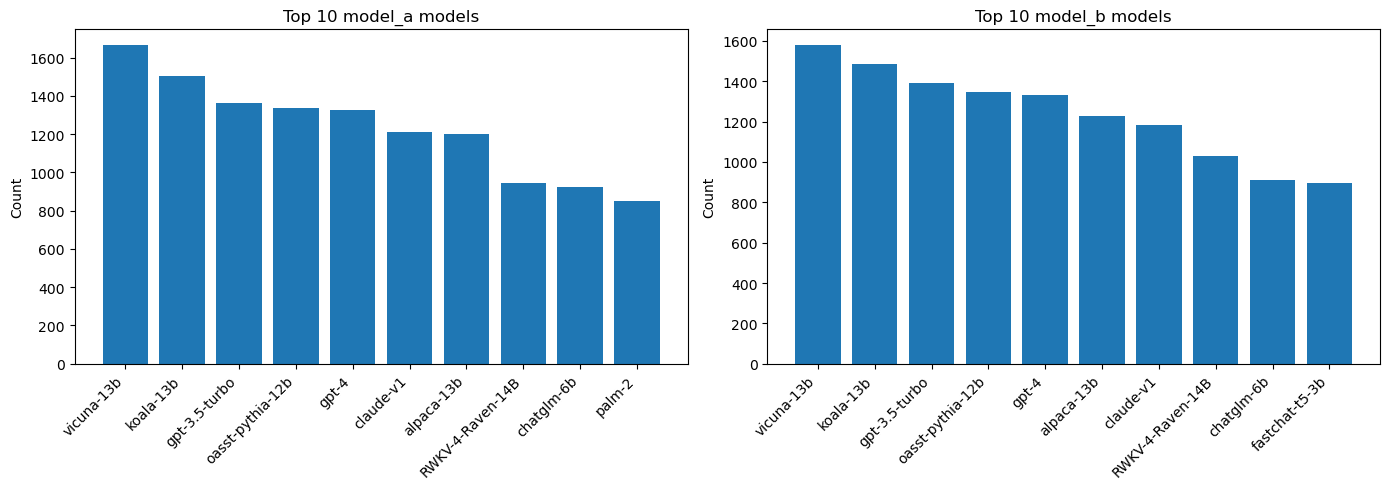

In [8]:
# your code here
df = pd.read_csv("data/chatbot_arena_conversations.csv")
df["label"] = df["winner_model_b"]
print("Shape:", df.shape)
display(df.head())

print("\nClass, 0 -> model_a won, 1 -> model_b won:")
print(df["label"].value_counts(normalize=True))

df["prompt_len"] = df["prompt"].fillna("").str.split().str.len()
df["response_a_len"] = df["response_a"].fillna("").str.split().str.len()
df["response_b_len"] = df["response_b"].fillna("").str.split().str.len()

plt.figure(figsize=(14, 5))
plt.subplot(1, 3, 1)
plt.hist(df["prompt_len"], bins=30)
plt.title("prompt lengths")
plt.xlabel("# of words")
plt.ylabel("count")

plt.subplot(1, 3, 2)
plt.hist(df["response_a_len"], bins=30)
plt.title("response_a lengths")
plt.xlabel("# of words")

plt.subplot(1, 3, 3)
plt.hist(df["response_b_len"], bins=30)
plt.title("response_b lengths")
plt.xlabel("# of words")
plt.tight_layout()
plt.show()

model_a_num = df["model_a"].value_counts().head(10)
model_b_num = df["model_b"].value_counts().head(10)

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.bar(model_a_num.index, model_a_num.values)
plt.title("Top 10 model_a models")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")

plt.subplot(1, 2, 2)
plt.bar(model_b_num.index, model_b_num.values)
plt.title("Top 10 model_b models")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


<div class="alert alert-success" style="color: #333; background-color: #e8fffb; border-color: #bcfff2; border-width: 1px; border-radius: 3px; padding: 10px;">
    
<b>Q1.1.3 - Filter the dataset</b>

<a id="q113"></a>
Instantiate tokenizer using `AutoTokenizer`. Analyze the token lengths of prompts and responses using the tokenizer. Filter the dataset to remove very long sequences that might cause memory issues during training. Specifically, limit prompt tokens to less than 100 and both response types to less than 400 tokens i.e `response_a` should be less than 400 tokens and `response_b` should also be less than 400 tokens. 
Display number of samples in the dataset with `dataframe.shape`

Tokenizer Settings -
- Be sure to set `tokenizer.pad_token = tokenizer.eos_token`
- Also recommended for good practice  `tokenizer.padding_side = "right"` and `tokenizer.add_eos_token = True`

*Note:* Reason we are limiting the number of tokens - longer texts will require more GPU memory and computation time. Assuming JupyterHub GPU, we believe total maxlen of 1024 tokens per sample should suffice.

</div>

In [9]:
# your code here
tokenizer = AutoTokenizer.from_pretrained(model_path)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

def count_tokens(text):
    return len(tokenizer.encode(str(text), add_special_tokens=True))

df["prompt_tokens"] = df["prompt"].apply(count_tokens)
df["response_a_tokens"] = df["response_a"].apply(count_tokens)
df["response_b_tokens"] = df["response_b"].apply(count_tokens)

train = df[
    (df["prompt_tokens"] < 100) &
    (df["response_a_tokens"] < 400) &
    (df["response_b_tokens"] < 400)
].reset_index(drop=True)

In [10]:
print("\nDataset shape after filtering:", train.shape)
print("\nLabel distribution after filtering:")
print(train.label.value_counts())


Dataset shape after filtering: (14223, 16)

Label distribution after filtering:
label
0    7161
1    7062
Name: count, dtype: int64


<!-- BEGIN QUESTION -->

<div class="alert alert-success" style="color: #333; background-color: #e8fffb; border-color: #bcfff2; border-width: 1px; border-radius: 3px; padding: 10px;">
<b>Q1.1.4</b>


<a id="q114"></a>
- At this point you should have ~14K samples. We are going to randomly sample (to save on training time) 600 samples of each label type ie. 600 samples with winner='model_a' and 600 samples winner='model_b'. Be sure to set random_state=42.

- Split the dataset into train and validation set with 80/20 split, stratify with label and random_state=42.

- We are also going to sort (ascending=False) the validation set by token length ie. sum prompt_tokens_len, response_a_tokens_len and response_b_tokens_len and then sort.
Why should we sort the validation set ? 

</div>


In [11]:
# your code here
df_sample = pd.concat([
    train[train["label"] == 0].sample(n=600, random_state=42),
    train[train["label"] == 1].sample(n=600, random_state=42)
]).reset_index(drop=True)

train_df, val_df = train_test_split(
    df_sample,
    test_size=0.2,
    stratify=df_sample["label"],
    random_state=42
)

val_df["total_tokens"] = (
    val_df["prompt_tokens"] +
    val_df["response_a_tokens"] +
    val_df["response_b_tokens"]
)
val_df = val_df.sort_values("total_tokens", ascending=False).reset_index(drop=True)


We should sort val_df descending because we want evaluation to start with the hardest sample and move to the shortest, so that we can include and learn from the more difficult responses and prompots which will help find weaknessses in the model's performance.

In [12]:
print("\nTraining set shape:", train_df.shape)
print("Validation set shape:", val_df.shape)
val_df.head()


Training set shape: (960, 16)
Validation set shape: (240, 17)


,question_id,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,id,label,prompt_len,response_a_len,response_b_len,prompt_tokens,response_a_tokens,response_b_tokens,total_tokens
0,6b31320632de4e0bbf9b63d3cc78c58e,claude-v1,oasst-pythia-12b,A table-tennis championship for $2^n$ players ...,* There are $2^n$ players total in the tournam...,To calculate the probability that two players ...,1,0,11885,0,46,195,192,69,392,306,767
1,129c71554ba942b3b3105c15932d4df7,gpt-3.5-turbo,chatglm-6b,"write me a story about Fur, who is a lonely sc...",Fur was a lonely school girl who had a hard ti...,Fur was a lonely school girl with no friends. ...,1,0,14012,0,40,322,295,49,377,338,764
2,5cb092594ca7413a9f7f57126de525ed,claude-v1,oasst-pythia-12b,What are some issues with the science of Back ...,There are several issues with the science depi...,Back to the Future is a 1985 American science ...,1,0,4300,0,13,303,326,15,356,386,757
3,eaf930cd08f943729b70dbbfcafd40e6,chatglm-6b,oasst-pythia-12b,I am a public account manager of a bank. How c...,"As a public account manager of a bank, it is y...","Sure, I'd be happy to help! To analyze the dat...",0,1,4442,1,28,273,297,31,353,365,749
4,20df2f0fbf504783a9fa3e31c9066165,wizardlm-13b,claude-instant-v1,explain the effects of diphenhydramine on the ...,Diphenhydramine is an antihistamine medication...,Diphenhydramine is an antihistamine medication...,0,1,19469,1,8,245,255,14,349,375,738


<div class="alert alert-success" style="color: #333; background-color: #e8fffb; border-color: #bcfff2; border-width: 1px; border-radius: 3px; padding: 10px;">

<b>Q1.2</b>

<a id="q12">**Creating a Tokenized Dataset for Model Training** </a>

Next, you'll create a tokenized dataset using [HuggingFace Datasets](https://huggingface.co/docs/datasets/index) library. To be specific - [from_pandas()](https://huggingface.co/docs/datasets/v3.4.1/en/package_reference/main_classes#datasets.Dataset.from_pandas).

However we cannot train model with raw text, we have to tokenize our text and it must return `input_ids`, `attention_mask` and corresponding `label` for every sample.

Here we provide you with skeleton, you should fill this appropriately.

```python

def tokenize(example, tokenizer):
    # 1. Format the input text with prompt and both responses. You have the freedom to prepend text with for eg: "Prompt:" and/or "Response A:" etc.

    # Combine the prompt and responses into a single text string
    
    # 2. Tokenize the text using the tokenizer
    # Make sure to set appropriate parameters for padding, truncation, etc. Set max_length to 1024
    
    # 3. Extract the input_ids and attention_mask
    
    # 4. Get the label from the example
    
    return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "labels": labels
        }

def load_data(df, tokenizer):
    # 1. Create a Dataset from the pandas DataFrame
    raw_datasets = Dataset.from_pandas(...)
    
    # 2. Apply the tokenize function to each example in the dataset
    # Make sure to:
    # - Pass the tokenizer to the function
    # - Remove original columns that are no longer needed
    # - Handle any other necessary parameters
    tokenized_datasets = raw_datasets.map(
        tokenize,
        ...
    )

    return tokenized_datasets
```

Expected output :

```python
print(tokenized_train)
print(tokenized_val)
```

```python
Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 960
})
Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 240
})
```
</div>


In [13]:
# your code here
def tokenize(example, tokenizer):
    text = (
        "Prompt: " + str(example["prompt"]) + "\n\n"
        + "Response A: " + str(example["response_a"]) + "\n\n"
        + "Response B: " + str(example["response_b"])
    )

    encoded = tokenizer(
        text,
        padding="max_length",
        truncation=True,
        max_length=1024,
        return_attention_mask=True
    )

    input_ids = encoded["input_ids"]
    attention_mask = encoded["attention_mask"]
    labels = example["label"]

    return {
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "labels": labels
    }

def load_data(df, tokenizer):
    raw_dataset = Dataset.from_pandas(df, preserve_index=False)
    tokenized_dataset = raw_dataset.map(
        lambda x: tokenize(x, tokenizer),
        remove_columns=raw_dataset.column_names
    )
    return tokenized_dataset

tokenized_train = load_data(train_df, tokenizer)
tokenized_val = load_data(val_df, tokenizer)

Map:   0%|          | 0/960 [00:00<?, ? examples/s]

Map:   0%|          | 0/240 [00:00<?, ? examples/s]

In [14]:
print(tokenized_train)
print(tokenized_val)

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 960
})
Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 240
})


<div class="alert alert-success" style="color: #333; background-color: #e8fffb; border-color: #bcfff2; border-width: 1px; border-radius: 3px; padding: 10px;">

<b>Q1.3 Setup LoraConfig and BitsAndBytesConfig </b>

Fine-tuning large language models like Llama 3.2 can be computationally expensive and memory-intensive. To address this, we utilize parameter-efficient fine-tuning techniques such as LoRA (Low-Rank Adaptation), which allows us to update only a small subset of the model's parameters, significantly reducing memory usage and training time while maintaining performance. Additionally, using quantization through BitsAndBytesConfig enables us to load and train the model with reduced precision (e.g., 4-bit or 8-bit), further optimizing memory usage and speeding up computations, especially with limited resources (GPUs.) 

<a id="q13"></a>

**[Lora Config](https://huggingface.co/docs/peft/en/package_reference/lora#peft.LoraConfig)**

We recommend following options -

```python
r=16,
lora_alpha=32,
lora_dropout=0.05,
bias='none',
inference_mode=False,
task_type=TaskType.SEQ_CLS,
target_modules=['q_proj', 'k_proj', 'v_proj',]
```

(a) Ask the following question to [Claude.ai](claude.ai) and [gemini.google.com](https://gemini.google.com/). Note: We are asking two AI models, in case one decides to hallucinate. Also recommended reference documentation - https://huggingface.co/docs/peft/main/en/conceptual_guides/lora

Explain the significance of following parameters - `r`, `lora_alpha` and `target_modules`

Write the answer in your own words - concisely - 3-5 sentences.


(b) **Quantization** - Apply 4-bit quantization using BitsAndBytesConfig. Recommended settings -

```python
load_in_4bit=True,
bnb_4bit_compute_dtype=torch.float16,
bnb_4bit_quant_type="nf4",
```


</div>


In [15]:
# your code here
# a)
lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias='none',
    inference_mode=False,
    task_type=TaskType.SEQ_CLS,
    target_modules=['q_proj', 'k_proj', 'v_proj']
)
# b)
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_quant_type="nf4"
)

According to Claude and Gemini, `r` determines the rank of the low rank matrices that are added to the model (essentially, how many new trainable parameters are introduced where small `r` is less parameters, less memory usage). `lora_alpha` is a scaling factor which adjusts the magnitude of the low rank updates before they are added to the model, contributing to how strong the LoRA layers affect the training.Then `target_modules` is what detemines which parts of the model in the attention part will be modified with LoRA.

<div class="alert alert-success" style="color: #333; background-color: #e8fffb; border-color: #bcfff2; border-width: 1px; border-radius: 3px; padding: 10px;">

<a id="q14"></a>
**1.4 Custom Classification Head for LLaMA**

In this question, you’ll implement a custom classification head for the pre-trained LLaMA model. Your task is to complete the implementation of the classifier by subclassing LlamaPreTrainedModel.

Your custom model should:
- Accept inputs (input_ids, attention_mask, labels, etc) and pass them through the pre-trained LLaMA model [LlamaModel](https://huggingface.co/docs/transformers/v4.49.0/en/model_doc/llama#transformers.LlamaModel).
- Extract embeddings from the last token of the sequence (based on attention mask).
- Classify embeddings into two labels using a linear layer `nn.Linear`.
- Output predictions using the Hugging Face standard SequenceClassifierOutput.

- Your class will resemble [LlamaForSequenceClassification](https://github.com/huggingface/transformers/blob/a22a4378d97d06b7a1d9abad6e0086d30fdea199/src/transformers/models/llama/modeling_llama.py#L893)

- We provide you with the loss function below.


Your implementation should match the following structure:

```python

class CS1090B_LlamaForClassification(LlamaPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)

        # YOUR CODE HERE
        pass
    
    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        position_ids=None,
        inputs_embeds=None,
        labels=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    )

        # YOUR CODE HERE


        # Calculate loss
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

        return SequenceClassifierOutput(
            loss=loss,
            logits=pooled_logits,
            hidden_states=outputs.hidden_states if output_hidden_states else None,
            attentions=outputs.attentions if output_attentions else None,
        )

```

</div>

In [16]:
# your code here
class CS1090B_LlamaForClassification(LlamaPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.model = LlamaModel(config)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)

        self.post_init()

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        position_ids=None,
        inputs_embeds=None,
        labels=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        # Accept inputs and pass them through pre-trained LLaMA
        outputs = self.model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            position_ids=position_ids,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict
        )

        hidden_states = outputs[0]

        # Extract embeddings from the last token of the sequence based on attention mask
        last_token_indices = attention_mask.sum(dim=1) - 1
        pooled_output = hidden_states[torch.arange(hidden_states.size(0)), last_token_indices]

        # Classify embeddings into 2 labels using a linear layer nn.Linear
        logits = self.classifier(pooled_output)

        # Output predictions using sequenceclassifieroutput
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states if output_hidden_states else None,
            attentions=outputs.attentions if output_attentions else None,
        )

In [17]:
## Test your model
if 0:
    model = CS1090B_LlamaForClassification.from_pretrained(
            model_path,
            quantization_config=quantization_config,
        )

    text = "Hello CS1090B!!"
    inputs = tokenizer(
        text,
        return_tensors="pt",
        padding="max_length",
        max_length=16,
        truncation=True
    )

    outputs = model(
            input_ids=inputs["input_ids"].to(device),
            attention_mask=inputs["attention_mask"].to(device)
        )
    print(outputs.logits)

    del model, outputs, inputs, text
    gc.collect()
    torch.cuda.empty_cache()

<div class="alert alert-success" style="color: #333; background-color: #e8fffb; border-color: #bcfff2; border-width: 1px; border-radius: 3px; padding: 10px;">

<a id="q15">**Q1.5 Metric and Training** </a>


<b>Q1.5.1 - Implementing Evaluation Metrics</b>

<a id="q151"></a>

Next, we are going to customize [`compute_metrics()`](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer.compute_metrics)` which will be utilized when we train our model.

Implement a `compute_metrics` function that takes evaluation predictions and calculates performance metrics. This function should:
- Take evaluation predictions as input (containing predictions and labels)
- Apply softmax to the raw prediction logits
- Calculate accuracy by comparing the predicted labels to the true labels
- Calculate log loss (cross-entropy) between the predicted probabilities and true labels
- Return a dictionary containing both metrics


```python
def compute_metrics(eval_pred):
    # Your code here

    return {
            "accuracy": accuracy,
            "log_loss": loss
        }
```


</div>

In [18]:
# your code here
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    probs = softmax(logits, axis=1)
    preds = np.argmax(probs, axis=1)
    accuracy = accuracy_score(labels, preds)
    loss = log_loss(labels, probs)

    return {
        "accuracy": accuracy,
        "log_loss": loss
    }

In [19]:
## Test your compute_metrics function

# Simulate predictions (logits) and true labels
num_samples = 5
num_classes = 2
np.random.seed(42)
logits = np.random.randn(num_samples, num_classes)
labels = np.random.randint(0, num_classes, size=num_samples)

# Create a mock object to simulate eval_pred
EvalPred = namedtuple("EvalPred", ["predictions", "label_ids"])
eval_pred = EvalPred(predictions=logits, label_ids=labels)

print(compute_metrics(eval_pred))
del num_samples, num_classes, logits, labels, eval_pred

{'accuracy': 0.6, 'log_loss': 0.555842872870483}


<div class="alert alert-success" style="color: #333; background-color: #e8fffb; border-color: #bcfff2; border-width: 1px; border-radius: 3px; padding: 10px;">

<b>Q1.5.2 - Model Training </b>

<a id="q152"></a>


Implement a complete training pipeline for the LLaMA classification model using the HuggingFace Trainer API. Your implementation should:

 - Load and prepare the tokenized datasets created earlier i.e. call `load_data()`
 - Initialize the CS1090B_LlamaForClassification model with the appropriate quantization configuration
 - Prepare the model for k-bit training [Link](https://huggingface.co/docs/peft/v0.15.0/en/package_reference/peft_model#peft.prepare_model_for_kbit_training). Recommended setting `use_gradient_checkpointing=False`
 - Apply the LoRA adapters using the configuration from Q1.3 [Link](https://huggingface.co/docs/peft/v0.15.0/en/package_reference/peft_model#peft.get_peft_model)
 - Print number of trainable parameters - `model.print_trainable_parameters()`
 - Configure training arguments with appropriate hyperparameters (learning rate, batch size, etc.) [Link](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.TrainingArguments)

```python
 Recommended parameters -

 training_args = TrainingArguments(
        output_dir="./results",
        num_train_epochs=1,
        per_device_train_batch_size=1,
        per_device_eval_batch_size=4,
        warmup_steps=50,
        weight_decay=0.01,
        logging_dir="./logs",
        logging_steps=10,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        push_to_hub=False,
        learning_rate=1e-4,
        report_to="none",
    )

```

 - Create a data collator for padding [Link](https://huggingface.co/docs/transformers/main/en/main_classes/data_collator#transformers.DataCollatorWithPadding)

 - Initialize the Trainer with the model, training arguments, tokenizer, datasets, data collator and evaluation metrics.
 - Execute the training process
 - Save the trained model
 - Evaluate the model on the validation set and report the results. Validation accuracy should be above 0.6.

 Note: Pay careful attention to batch sizes and gradient checkpointing settings, as these can significantly impact training time and memory usage. Approx. expected training time on JuputerHub ~35mins.

</div>

In [20]:
# your code here
tokenized_train = load_data(train_df, tokenizer)
tokenized_val = load_data(val_df, tokenizer)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_quant_type="nf4"
)

model = CS1090B_LlamaForClassification.from_pretrained(
    model_path,
    quantization_config=bnb_config,
)

model = prepare_model_for_kbit_training(model, use_gradient_checkpointing=False)
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=1,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=4,
    warmup_steps=50,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=False,
    learning_rate=1e-4,
    report_to="none",
)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()
trainer.save_model("./evaluation/final_model")
evaluation = trainer.evaluate()
print("Evaluation:", evaluation)

Map:   0%|          | 0/960 [00:00<?, ? examples/s]

Map:   0%|          | 0/240 [00:00<?, ? examples/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of CS1090B_LlamaForClassification were not initialized from the model checkpoint at meta-llama/Llama-3.2-3B-Instruct and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 6,428,674 || all params: 3,219,184,644 || trainable%: 0.1997


/tmp/ipykernel_19843/2535603319.py:39: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Epoch,Training Loss,Validation Loss,Accuracy,Log Loss,Runtime,Samples Per Second,Steps Per Second
1,1.779600,1.573027,0.670833,1.573027,322.847300,0.743000,0.186000


Evaluation: {'eval_loss': 1.57302725315094, 'eval_accuracy': 0.6708333333333333, 'eval_log_loss': 1.5730273764854772, 'eval_runtime': 306.2115, 'eval_samples_per_second': 0.784, 'eval_steps_per_second': 0.196, 'epoch': 1.0}


<div class="alert alert-success" style="color: #333; background-color: #e8fffb; border-color: #bcfff2; border-width: 1px; border-radius: 3px; padding: 10px;">

<b>Q1.6 - Predict and Display Confusion Matrix </b>

<a id="q16"></a>

Run the cell below to display confusion matrix on validation set
</div>

(240, 2)


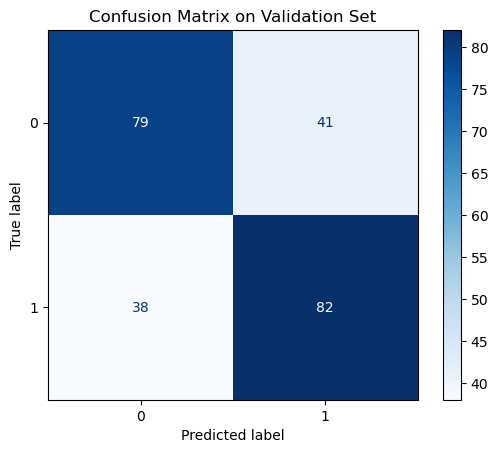

In [21]:
# `tokenized_val` is a HuggingFace Dataset object
output = trainer.predict(tokenized_val)
logits = output.predictions  
print(logits.shape)

predicted_classes = np.argmax(logits, axis=1)

true_labels = output.label_ids


cm = confusion_matrix(true_labels, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix on Validation Set")
plt.show()


In [22]:
time_end = time.time()
print(f"It took {(time_end - time_start)/60:.2f} minutes for this notebook to run")

It took 59.66 minutes for this notebook to run


**This concludes Part 1 👏**

**Please continue to Parts 2 & 3 inthe second notebook**